In [1]:
import pandas
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import numpy as np
from praveganb.idracdemo import *
from praveganb.idracdemo import IdracData as VsphereData
import seaborn as sns
%matplotlib inline

In [2]:
vspheredata = VsphereData(scope='vsphere', stream='vmware', gateway='10.243.37.84:80')

In [3]:
stream_info = vspheredata.get_stream_start_end()
print('Start: {0}'.format(stream_info[0]))
print('End: {0}'.format(stream_info[1]))

Start: H4sIAAAAAAAAADOwKisuyEgtStUvyy1PLEq1MgBBAJDxAa0WAAAA
End: H4sIAAAAAAAAADOwKisuyEgtStUvyy1PLEq1MgBCMwNTS2NjQ0MjU0MAijerLCAAAAA=


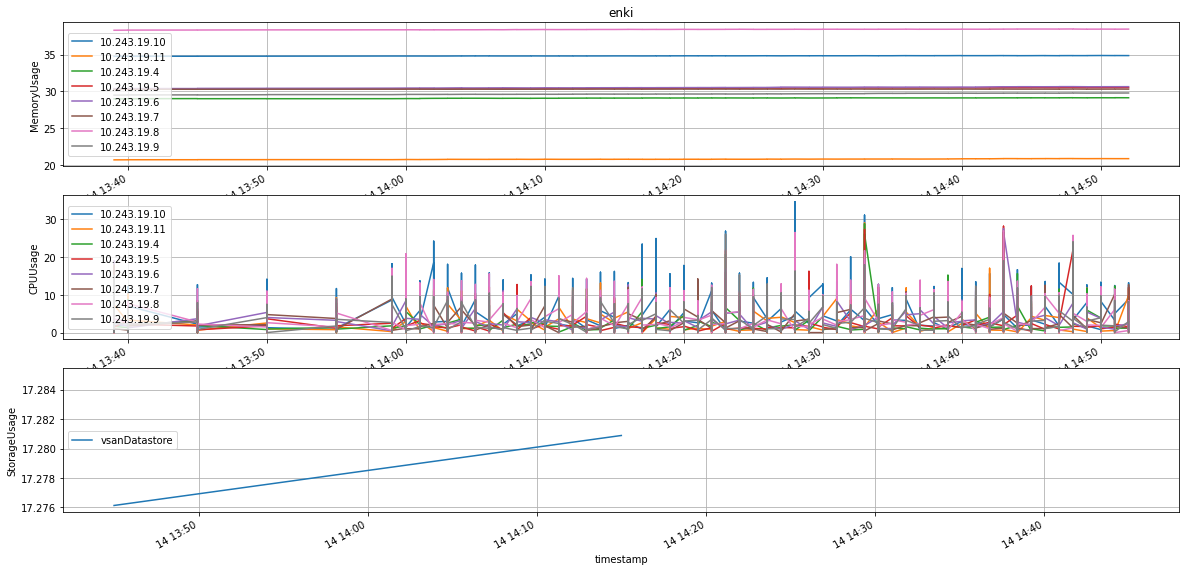

_MultiThreadedRendezvous: <_MultiThreadedRendezvous of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = ""
	debug_error_string = "{"created":"@1587008096.840692076","description":"Error received from peer ipv4:10.243.37.180:80","file":"src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"","grpc_status":2}"
>

In [6]:
metrics = vspheredata.get_metric_from_vsphere(stream_info[0])
data  = dict.fromkeys(['MemoryUsage', 'CPUUsage', 'StorageUsage'], dict())
rackLabel = "enki"
vcenter = "vcenter.{0}.local".format(rackLabel)
datastores = ["vsanDatastore"] #, "isilon-shared-n1"]
for k, v in data.items():
    data[k] = pandas.DataFrame()
for _metric in metrics:
    clear_output(wait=True)
    df = pandas.json_normalize([metric for metric in _metric['metrics'] if metric['name'] == 'vsphere_host_mem'])
    df1 = pandas.json_normalize([metric for metric in _metric['metrics'] if metric['name'] == 'vsphere_host_cpu'])
    df2 = pandas.json_normalize([metric for metric in _metric['metrics'] if metric['name'] == 'vsphere_datastore_disk'])
    
    
    if 'timestamp' in df.keys():
        df['timestamp'] = pandas.to_datetime(df['timestamp'], unit='s')
        df.set_index('timestamp', inplace=True)
        df = df[(df["tags.vcenter"] == vcenter) & (df["tags.clustername"] == "compute")]
        data['MemoryUsage'] = data['MemoryUsage'].append(df)
    if 'timestamp' in df1.keys():
        df1['timestamp'] = pandas.to_datetime(df1['timestamp'], unit='s')
        df1.set_index('timestamp', inplace=True)
        df1 = df1[(df1["tags.vcenter"] == vcenter) & (df1["tags.clustername"] == "compute")]
        data['CPUUsage'] = data['CPUUsage'].append(df1)
    if 'timestamp' in df2.keys():
        df2['timestamp'] = pandas.to_datetime(df2['timestamp'], unit='s')
        df2.set_index('timestamp', inplace=True)
        df2 = df2[(df2["tags.vcenter"] == vcenter) & (df2["tags.source"].isin(datastores))]
        #  mean("used_latest") * (100 / mean("capacity_latest")
        df2["fields.usage_average"] = df2["fields.used_latest"] * (100/df2["fields.capacity_latest"])
        data['StorageUsage'] = data['StorageUsage'].append(df2)
    fig, axes = plt.subplots(nrows=len(data), ncols=1)
    
    i = 0
    for k, v in data.items():
        if data[k].empty:
            continue
        #data[k].groupby('tags.source')['fields.usage_average'].mean().plot(ax=axes[i], figsize=(20,10), kind='bar')
        data[k].groupby('tags.source')['fields.usage_average'].plot(ax=axes[i], figsize=(20,10), grid=True)

        axes[i].set_ylabel(k)
        if i == 0 :
            axes[i].set_title(rackLabel)
        axes[i].legend(loc='center left')
        i+=1
    plt.show()
        